In [1]:
import subprocess

def install(name):
    subprocess.call(['pip', 'install', name])

install('nibabel')
install('scikit-learn')

In [1]:
import numpy as np
import os
import glob
import sys
import nibabel as nib
import matplotlib.pyplot as plt

# Importing our model
MY_UTILS_PATH = "../src/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet
import tensorflow as tf
# Importing callbacks and data augmentation utils

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#input paramters default (batch_size=5, string=iki, lr=1e-4, w1,w2=0.5,0.5)
H,W = (512,512)
epochs = 150
string = 'iki'
batch_size= 5
patience = 20
lr = 1e-4
decay = 1e-7
c1,c2 = 20,-20
w1,w2 = 0, 1
model_name = "../models/end-to-end-10x.hdf5"

In [3]:
#file ids for all training pairs
training_files = np.loadtxt('../data/train.txt', dtype=str)
validation_files = np.loadtxt('../data/val.txt', dtype=str)

In [6]:
training_files

array([['TUM37-20190108.nii', 'TUM37-20191105.nii'],
       ['TUM37-20190730.nii', 'TUM37-20191105.nii'],
       ['TUM36-20181030.nii', 'TUM36-20190527.nii'],
       ['TUM29-20180125.nii', 'TUM29-20180716.nii'],
       ['TUM28-20180821.nii', 'TUM28-20181120.nii'],
       ['TUM27-20180716.nii', 'TUM27-20190104.nii']], dtype='<U18')

In [7]:
validation_files

array([['TUM25-20181009.nii', 'TUM25-20190910.nii'],
       ['TUM25-20190305.nii', 'TUM25-20190910.nii'],
       ['TUM24-20181206.nii', 'TUM24-20190417.nii'],
       ['TUM20-20180205.nii', 'TUM20-20180402.nii'],
       ['TUM21-20171127.nii', 'TUM21-20190304.nii']], dtype='<U18')

In [8]:
ref_path = '../../../data/brain-cancer/'
next_path = '../data/zero_filled_rec/10x/'
ref_reg_path = '../data/reference_reg_10x/'

In [9]:
#pathes to training data
train_previous_files = [ref_reg_path + 'elastic_' + moving[:-4] + '_' + fixed for moving, fixed in zip(training_files[:,0],training_files[:,1])]
train_follow_up_files = [ref_path + file for file in training_files[:,1]]
#train_follow_up_files = [next_path + file for file in training_files[:,1]]
train_reference_files = [ref_path + file for file in training_files[:,1]]

In [10]:
#pathes to validation data
val_previous_files = [ref_reg_path + 'elastic_' + moving[:-4] + '_' + fixed for moving, fixed in zip(validation_files[:,0],validation_files[:,1])]
val_follow_up_files = [ref_path + file for file in validation_files[:,1]]
val_reference_files = [ref_path + file for file in validation_files[:,1]]

Need to load 3 inputs: [kspace, previous_rec, under_masks]
Need one output: [ref]

load kspace of zero-filled/follow-up files where imag and real channels separate

In [11]:
def load_data(follow_up_files, previous_files, reference_files, c1=20,c2=-20):
    kspace = []
    rec = []
    previous = []
    ref = []
    for ii, file in enumerate(follow_up_files):
        img = nib.load(file).get_fdata()[:,:,c1:c2]
        aux_rec  = np.swapaxes(img,0,2)
        #aux_rec = (aux_rec - np.mean(aux_rec))/ np.std(aux_rec)
        aux_rec = aux_rec / np.abs(aux_rec).max()

        #convert zero filled reconstruction to kspace
        f = np.fft.fft2(aux_rec)
        aux_kspace = np.zeros((*aux_rec.shape,2))
        aux_kspace[:,:,:,0] = f.real
        aux_kspace[:,:,:,1] = f.imag
        kspace.append(aux_kspace)

        #obtain complex reconstruction by taking inverse fft
        complex_rec = np.fft.ifft2(f)
        aux2_rec = np.zeros((*aux_rec.shape,2))
        aux2_rec[:,:,:,0] = complex_rec.real
        aux2_rec[:,:,:,1] = complex_rec.imag
        rec.append(aux2_rec)

        #load previous registered reconstruction
        img2 = nib.load(previous_files[ii]).get_fdata()[:,:,c1:c2]
        previous_rec = np.swapaxes(img2,0,2)[...,np.newaxis]
        #previous_rec = (previous_rec - np.mean(previous_rec)) / np.std(previous_rec)
        previous_rec = previous_rec / np.abs(previous_rec).max()
        previous.append(previous_rec)
        
        #load reference reconstruction
        img3 = nib.load(reference_files[ii]).get_fdata()[:,:,c1:c2]
        ref_rec = np.swapaxes(img3,0,2)[:,:,:,np.newaxis]
        #ref_rec = (ref_rec - np.mean(ref_rec)) / np.std(ref_rec)
        ref_rec = ref_rec / np.abs(ref_rec).max()
        ref.append(ref_rec)
    kspace = np.concatenate(kspace,axis=0)
    rec = np.concatenate(rec)
    previous = np.concatenate(previous)
    ref = np.concatenate(ref)
    return kspace, rec, previous, ref
    

In [12]:
train_kspace, train_rec, train_previous, train_ref = load_data(train_follow_up_files, train_previous_files, train_reference_files)
val_kspace, val_rec, val_previous, val_ref = load_data(val_follow_up_files, val_previous_files, val_reference_files)

In [16]:
print(train_kspace.shape, train_rec.shape)

(662, 512, 512, 2) (662, 512, 512, 2)


In [17]:
print(val_kspace.shape, val_previous.shape, val_ref.shape)

(656, 512, 512, 2) (656, 512, 512, 1) (656, 512, 512, 1)


In [18]:
#generate masks for k-space data of zero_filled reconstruction
#there may be a better way of implementing this but will try this first
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../data/sampling_masks/R10_512x512_poisson_center_true_radius_40_r_2.66.npy"),axes=(1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                               
                                   axis = -1)
# Undersampling the training set
#indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),train_kspace.shape[0],replace = True)
#train_var_sampling_mask = (var_sampling_mask[indexes])

# Undersampling the validation set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),val_kspace.shape[0],replace = True)
val_var_sampling_mask = (var_sampling_mask[indexes])
val_kspace[val_var_sampling_mask] = 0

(512, 512)
(512, 512)
(512, 512)
(512, 512)


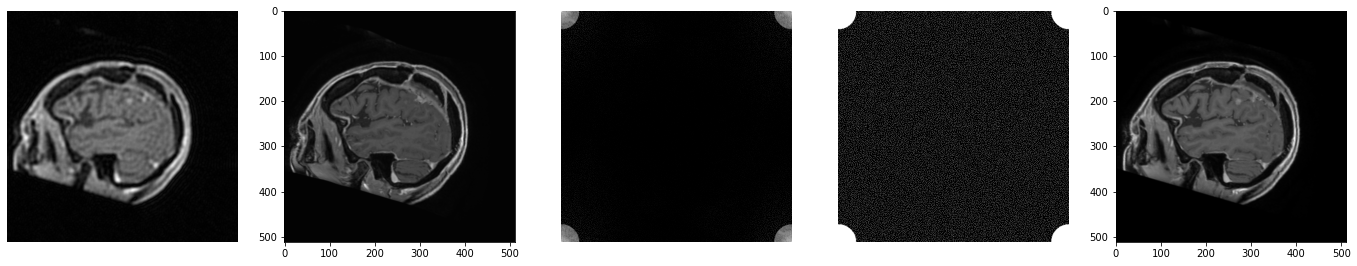

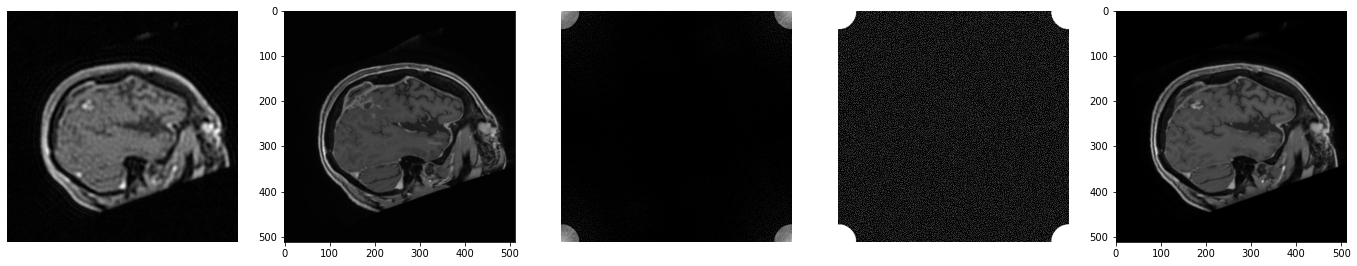

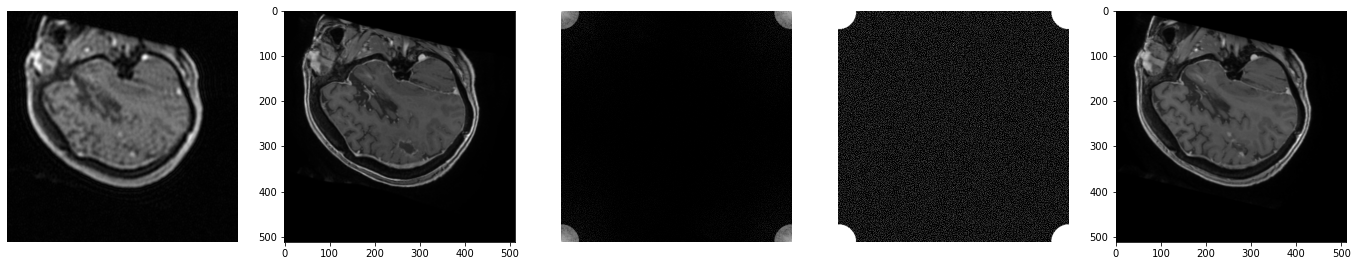

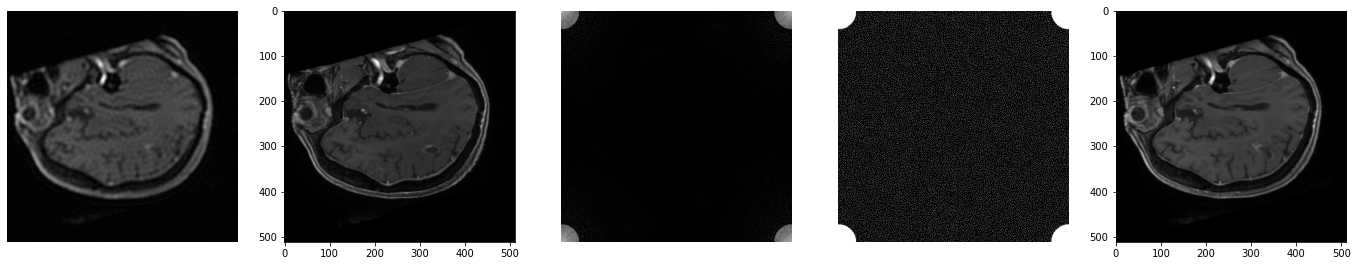

In [19]:
# On the fly data augmentation
def combine_generator(gen1,gen2,gen3,under_masks):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        f = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        
        #under_sample k-space
        kspace2 = np.zeros((f.shape[0],f.shape[1],f.shape[2],2))
        kspace2[:,:,:,0] = f.real
        kspace2[:,:,:,1] = f.imag
        indexes = np.random.choice(np.arange(under_masks.shape[0], dtype=int), rec_real.shape[0], replace=False)
        kspace2[under_masks[indexes]] = 0
        
        #previous scan and reference
        previous_rec = gen3.next()
        rec = np.abs(rec_real[:,:,:,0] + 1j*rec_imag[:,:,:,0])
        rec = rec[:,:,:,np.newaxis]
        
        yield([kspace2, previous_rec, under_masks[indexes].astype(np.float32)],[rec, rec])
        
seed = 905
image_datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen3 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_generator1 = image_datagen1.flow(train_rec[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)
image_generator2 = image_datagen2.flow(train_rec[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)        
image_generator3 = image_datagen3.flow(train_previous[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)        



combined = combine_generator(image_generator1,image_generator2, image_generator3, var_sampling_mask)

# Dispaly sample data augmentation
counter = 0
for ii in combined:
    
    fback = np.fft.ifft2(ii[0][0][4,:,:,0]+1j*ii[0][0][4,:,:,1])
    print(fback.shape)
    zero_filled_rec = np.abs(fback.real+1j*fback.imag)
    plt.figure(figsize=(24,10))
    #under sampled reconstruction 
    plt.subplot(151)
    plt.imshow(zero_filled_rec,cmap = 'gray')
    plt.axis("off")
    #previous scan
    plt.subplot(152)
    plt.imshow(ii[0][1][4,:,:,0], cmap='gray')
    #undersampled k-space
    plt.subplot(153)
    plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
    plt.axis("off")
    #sampling mask
    plt.subplot(154)
    plt.imshow(ii[0][0][4,:,:,0].astype(bool),cmap = 'gray')
    plt.axis("off")
    #fully sampled reconstruction
    plt.subplot(155)
    plt.imshow(ii[1][0][4,:,:,0], cmap='gray')
    counter+=1
    if counter > 3:
        break

In [20]:
var_sampling_mask.shape

(100, 512, 512, 2)

In [21]:
os.makedirs('../models/', exist_ok=True)


# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

In [22]:
# Training our model
model = fsnet.deep_cascade_flat_unrolled_end(string, H=H,W=W)
opt = Adam(learning_rate = lr,decay = decay)
model.compile(loss = ['mse','mse'],loss_weights=[w1,w2],optimizer=opt)
print(model.summary())

hist = model.fit(combined,
             epochs=epochs,
             steps_per_epoch=train_ref.shape[0]//batch_size,
             verbose=1,
             validation_data= ([val_kspace,val_previous,val_var_sampling_mask],[val_ref, val_ref]),
             callbacks=[checkpoint,earlyStopping])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 2) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 48) 912         lambda[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 48) 0           conv2d[0][0]                     
______________________________________________________________________________________________

Epoch 1/100
132/132 [==============================] - 82s 579ms/step - loss: 1.8859e-04 - lambda_5_loss: 2.2099e-04 - tf.expand_dims_1_loss: 1.5619e-04 - val_loss: 1.9251e-04 - val_lambda_5_loss: 2.3281e-04 - val_tf.expand_dims_1_loss: 1.5221e-04
Epoch 2/100
132/132 [==============================] - 63s 477ms/step - loss: 1.3984e-04 - lambda_5_loss: 1.6594e-04 - tf.expand_dims_1_loss: 1.1373e-04 - val_loss: 1.7513e-04 - val_lambda_5_loss: 2.0722e-04 - val_tf.expand_dims_1_loss: 1.4304e-04
Epoch 3/100
132/132 [==============================] - 63s 476ms/step - loss: 1.2457e-04 - lambda_5_loss: 1.4831e-04 - tf.expand_dims_1_loss: 1.0084e-04 - val_loss: 1.7039e-04 - val_lambda_5_loss: 2.0480e-04 - val_tf.expand_dims_1_loss: 1.3599e-04
Epoch 4/100
132/132 [==============================] - 62s 474ms/step - loss: 1.1544e-04 - lambda_5_loss: 1.3775e-04 - tf.expand_dims_1_loss: 9.3125e-05 - val_loss: 1.6970e-04 - val_lambda_5_loss: 1.9958e-04 - val_tf.expand_dims_1_loss: 1.3981e-04
Epoch 5/

Epoch 34/100
132/132 [==============================] - 62s 473ms/step - loss: 7.6519e-05 - lambda_5_loss: 9.6316e-05 - tf.expand_dims_1_loss: 5.6721e-05 - val_loss: 1.0512e-04 - val_lambda_5_loss: 1.3085e-04 - val_tf.expand_dims_1_loss: 7.9383e-05
Epoch 35/100
132/132 [==============================] - 62s 474ms/step - loss: 7.5252e-05 - lambda_5_loss: 9.4675e-05 - tf.expand_dims_1_loss: 5.5829e-05 - val_loss: 1.0435e-04 - val_lambda_5_loss: 1.2939e-04 - val_tf.expand_dims_1_loss: 7.9310e-05
Epoch 36/100
132/132 [==============================] - 62s 474ms/step - loss: 7.4644e-05 - lambda_5_loss: 9.3960e-05 - tf.expand_dims_1_loss: 5.5327e-05 - val_loss: 1.0430e-04 - val_lambda_5_loss: 1.2924e-04 - val_tf.expand_dims_1_loss: 7.9356e-05
Epoch 37/100
132/132 [==============================] - 62s 474ms/step - loss: 7.4408e-05 - lambda_5_loss: 9.3683e-05 - tf.expand_dims_1_loss: 5.5132e-05 - val_loss: 1.0276e-04 - val_lambda_5_loss: 1.2746e-04 - val_tf.expand_dims_1_loss: 7.8065e-05
Epoc

Epoch 67/100
132/132 [==============================] - 62s 474ms/step - loss: 6.5904e-05 - lambda_5_loss: 8.3038e-05 - tf.expand_dims_1_loss: 4.8770e-05 - val_loss: 1.0023e-04 - val_lambda_5_loss: 1.2366e-04 - val_tf.expand_dims_1_loss: 7.6807e-05
Epoch 68/100
132/132 [==============================] - 63s 474ms/step - loss: 6.5830e-05 - lambda_5_loss: 8.3009e-05 - tf.expand_dims_1_loss: 4.8650e-05 - val_loss: 1.0646e-04 - val_lambda_5_loss: 1.3184e-04 - val_tf.expand_dims_1_loss: 8.1082e-05
Epoch 69/100
132/132 [==============================] - 62s 474ms/step - loss: 6.5836e-05 - lambda_5_loss: 8.2823e-05 - tf.expand_dims_1_loss: 4.8849e-05 - val_loss: 1.1346e-04 - val_lambda_5_loss: 1.4109e-04 - val_tf.expand_dims_1_loss: 8.5834e-05
Epoch 70/100
132/132 [==============================] - 62s 474ms/step - loss: 6.5586e-05 - lambda_5_loss: 8.2627e-05 - tf.expand_dims_1_loss: 4.8544e-05 - val_loss: 1.1676e-04 - val_lambda_5_loss: 1.4332e-04 - val_tf.expand_dims_1_loss: 9.0188e-05
Epoc

Epoch 100/100
132/132 [==============================] - 62s 472ms/step - loss: 6.1352e-05 - lambda_5_loss: 7.7436e-05 - tf.expand_dims_1_loss: 4.5268e-05 - val_loss: 9.2117e-05 - val_lambda_5_loss: 1.1540e-04 - val_tf.expand_dims_1_loss: 6.8835e-05
